# Melanoma Detection CNN

#### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Project Steps
#### Data Reading/Data Understanding
#### Dataset Creation
#### Dataset visualisation
#### Model Building & training
#### Model Building & training on the augmented data
#### Class distribution and Handling
#### Model Building & training on the rectified class imbalance data

## Data Reading/Data Understanding

In [20]:
!pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 208.3 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
#import required libraries
import pathlib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [2]:
#loading the train and test dataset
data_dir_train = pathlib.Path('Train')
data_dir_test = pathlib.Path('Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load images using keras.preprocessing

In [4]:
#defining the dataset parameters
batch_size = 32
image_height = 180
image_width = 180

In [5]:
#training set

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
training_set = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    seed=123,
    subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-07-10 08:46:16.197991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-10 08:46:16.198014: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-10 08:46:16.198027: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-10 08:46:16.198210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 08:46:16.198232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
#validation set

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_set = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    seed=123,
    subset='validation',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = training_set.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
num_classes = len(class_names)
print(num_classes)

9


### Visualize the data

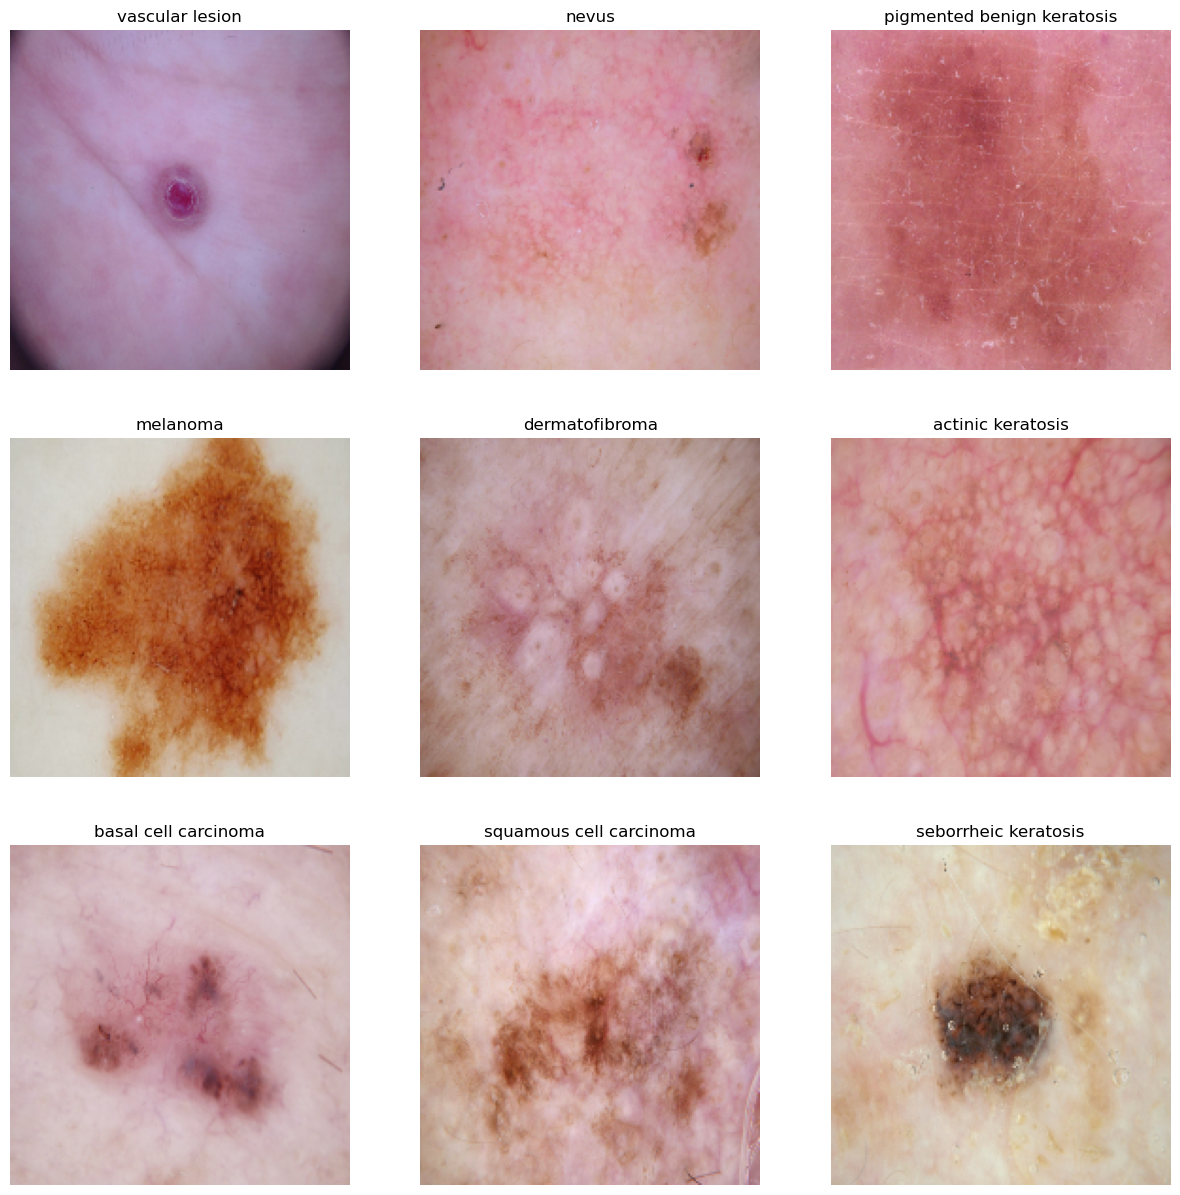

In [9]:
# visualising one image from each class
class_examples = {}

# Iterate through the dataset to extract one example per class
for images, labels in training_set:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        if class_name not in class_examples:
            class_examples[class_name] = img
        # Break if we have one example for each class
        if len(class_examples) == len(class_names):
            break
    if len(class_examples) == len(class_names):
        break

# Plot the examples
plt.figure(figsize=(15, 15))
for i, (class_name, img) in enumerate(class_examples.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

In [10]:
# normalizing the image to 0, 1 using layers.experimental.preprocessing.Rescaling

normalization_layer = layers.Rescaling(1./255)

# Apply the normalization to the datasets
training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))
# training_set = training_set.map(lambda x, y: (normalization_layer(x), y))

In [11]:
print(training_set)

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [12]:
# store the dataset in the cache to prevent loading the data for each epoch

AUTOTUNE = tf.data.experimental.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
print(training_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Model Building & training

In [15]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after pooling layer
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after pooling layer
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after pooling layer
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout before dense layer
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,681 (50.49 MB)

 Trainable params: 13,235,721 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile the model

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train the model

In [18]:
epochs = 20
history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/20


2024-07-10 08:46:45.473824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.3066 - loss: 2.2348 - val_accuracy: 0.1499 - val_loss: 4.2388
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.4804 - loss: 1.5070 - val_accuracy: 0.1499 - val_loss: 3.6348
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.5119 - loss: 1.3758 - val_accuracy: 0.1499 - val_loss: 4.5955
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.5563 - loss: 1.2554 - val_accuracy: 0.1499 - val_loss: 3.1575
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.5477 - loss: 1.2072 - val_accuracy: 0.1499 - val_loss: 4.0472
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.5705 - loss: 1.1769 - val_accuracy: 0.2394 - val_loss: 3.0742
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.6455 - loss: 0.9932 - val_accuracy: 0.1834 - val_loss: 3.0178
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.6340 - loss: 0.9687 - val_accuracy: 0.266

It seems that the model is overfitting to the training dataset as the accuracy for the test dataset is 91.36 and the validation set accuracy is 54.36 which is too low compared to the training accuracy

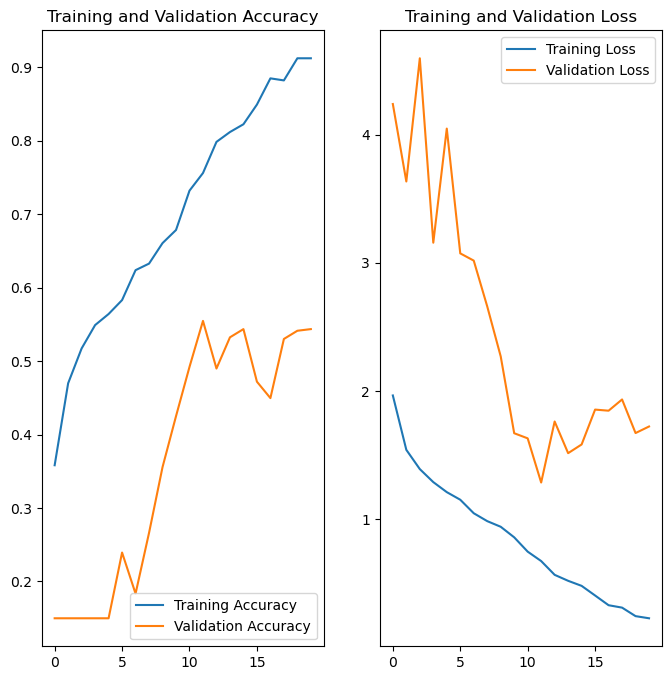

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

### Augmentation Techniques Used
- RandomFlip
- RandomRotation
- RandomZoom
- RandomBrightness
- RandomTranslation
- RandomContrast

In [22]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Apply data augmentation to training set
augmented_training_set = training_set.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)


In [23]:
# Prefetching to improve performance
augmented_training_set = augmented_training_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [24]:
# Fit the model
epochs = 20
history = model.fit(
  augmented_training_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.5421 - loss: 1.6614 - val_accuracy: 0.3870 - val_loss: 2.7669
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.5286 - loss: 1.3842 - val_accuracy: 0.2416 - val_loss: 2.4683
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.5529 - loss: 1.2905 - val_accuracy: 0.4609 - val_loss: 1.5795
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.5585 - loss: 1.2014 - val_accuracy: 0.4922 - val_loss: 1.6106
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.5981 - loss: 1.1213 - val_accuracy: 0.5190 - val_loss: 1.3527
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.6100 - loss: 1.0556 - val_accuracy: 0.5190 - val_loss: 1.4034
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.6220 - loss: 1.0746 - val_accuracy: 0.4497 - val_loss: 2.1400
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.6241 - loss: 1.0622 - val_accu

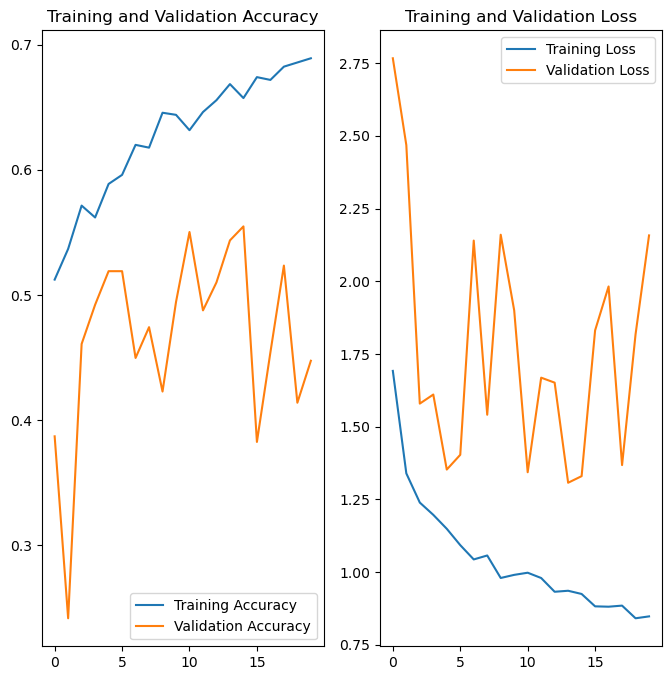

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Augmented dataset Training Findings

It is clear that after adding the data augmentation the overfitting of the model reduced drastically

### Handling class imbalances using Augmentor

In [26]:
!pip install Augmentor


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [31]:
path_to_training_dataset=pathlib.Path('Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x321134290>: 100%|█| 500/500 [00:01<00:00, 253.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3D7761510>: 100%|█| 500/500 [00:01<00:00, 300.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x362C6A510>: 100%|█| 500/500 [00:01<00:00, 292.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x362F56B50>: 100%|█| 500/500 [00:09<00:00, 53.70 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x361E8FB90>: 100%|█| 500/500 [00:08<00:00, 62.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x362FA6C90>: 100%|█| 500/500 [00:01<00:00,


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3210A0550>: 100%|█| 500/500 [00:04<00:00, 122.36 Samples/s


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3D7760710>: 100%|█| 500/500 [00:01<00:00, 284.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x362FB80D0>: 100%|█| 500/500 [00:01<00:00, 259.95 Samples/s]


In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [35]:
import glob
import os

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_59938e1d-3494-49d2-9287-45c1a7bcf6c3.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_802a8878-10f8-4c61-9a88-584cbe9b273b.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010597.jpg_e88ba0fc-33db-497b-84b1-0011cd0800aa.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009905.jpg_5c7c2663-5335-4744-80c6-feefa1b9a52c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010011.jpg_576bc04e-9699-47a5-933c-fad5f3e20ade.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_6f51cfe5-20fd-4c0d-ad72-cad99edae772.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010803.jpg_c2a61a0b-4ff2-4cff-a8db-036c413d549e.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_bfc48f6a-9885-44cc-9a5e-a5f448f3772e.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010629.jpg_cb1445ef-d495-487b-823c-f56d5675d591.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000152.jpg_290f0e14-d482-4e8f-9ade

#### Train the model on the data created using Augmento

In [37]:
#defining the dataset parameters
batch_size = 32
image_height = 180
image_width = 180

In [38]:
#training set

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
training_set = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    seed=123,
    subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
#validation set

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_set = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    seed=123,
    subset='validation',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Training the augmented dataset on the same model

In [41]:
# Fit the model
epochs = 20
history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.6359 - loss: 0.9968 - val_accuracy: 0.3422 - val_loss: 2.3058
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.7483 - loss: 0.6827 - val_accuracy: 0.3601 - val_loss: 2.0057
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - accuracy: 0.7820 - loss: 0.5700 - val_accuracy: 0.5056 - val_loss: 1.7983
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.8252 - loss: 0.4530 - val_accuracy: 0.7721 - val_loss: 0.6675
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.8635 - loss: 0.3540 - val_accuracy: 0.5709 - val_loss: 1.4045
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.8579 - loss: 0.3735 - val_accuracy: 0.6370 - val_loss: 1.1780
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 339ms/step - accuracy: 0.8641 - loss: 0.3714 - val_accuracy: 0.6192 - val_loss: 1.3470
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 302ms/step - accuracy: 0.8591 - loss: 0

## Findings

- From this it is clear that the model performance have been increased drastically both on train and validation data
- The overfitting behaviour of the model is also has been controlled all though by the end the model seems over fitting we could consider adding some early stopping to prevent overfitting and resource wastage

#### Building new optimised model to test the augmented data

In [79]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after pooling layer
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after pooling layer
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),  # Dropout after pooling layer
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout before dense layer
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

In [80]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
#Adding early stopping to prevent resource wastage and restore best weights
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [85]:
epochs = 20
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 697ms/step - accuracy: 0.4724 - loss: 1.4478 - val_accuracy: 0.1759 - val_loss: 5.0109
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 696ms/step - accuracy: 0.5168 - loss: 1.2872 - val_accuracy: 0.4543 - val_loss: 1.6431
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 99s 581ms/step - accuracy: 0.6047 - loss: 1.0607 - val_accuracy: 0.3088 - val_loss: 3.0539
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 570ms/step - accuracy: 0.6685 - loss: 0.8868 - val_accuracy: 0.3578 - val_loss: 2.3493
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 574ms/step - accuracy: 0.7224 - loss: 0.7213 - val_accuracy: 0.5501 - val_loss: 1.4516
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 95s 560ms/step - accuracy: 0.7783 - loss: 0.6126 - val_accuracy: 0.4402 - val_loss: 1.9774
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 591ms/step - accuracy: 0.8153 - loss: 0.5218 - val_accuracy: 0.5620 - val_loss: 1.4116
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 99s 587ms/step - accuracy: 0.8450 - loss

#### Findings

- The new model seems much better than the old one
- As we added the early stopping the model stoped training at epoch 14 and gained the best weights for the training as the val_accuracy don't have significant changes
- It seems that the model is not too much ovefitting to the training data as compared to the initial models and data without augmentation